# Q1: Cross-Currency Basis Project Structure and BTCUSDT Data

This notebook sets up the project structure and a BTCUSDT-focused workflow (loading, cleaning, validating, and plotting with seaborn). It prepares the ground for Question 1 (cross-currency basis BTC/USDT vs BTC/USD).

# 1. Set Up Project Folder Structure

In this section we ensure a reproducible project layout for all BTCUSDT and BTC/USD work (raw, processed data, notebooks, source code, and tests).


In [208]:
# Ensure base project layout exists using pathlib

from pathlib import Path



project_root = Path.cwd().resolve().parent



for sub in ["data/raw", "data/processed", "notebooks", "src", "tests"]:

    target = project_root / sub

    target.mkdir(parents=True, exist_ok=True)

    print(f"Ensured directory exists: {target}")


Ensured directory exists: /Users/tobias/Desktop/PROG/IAQF/data/raw
Ensured directory exists: /Users/tobias/Desktop/PROG/IAQF/data/processed
Ensured directory exists: /Users/tobias/Desktop/PROG/IAQF/notebooks
Ensured directory exists: /Users/tobias/Desktop/PROG/IAQF/src
Ensured directory exists: /Users/tobias/Desktop/PROG/IAQF/tests


# 2. Create and Configure Python Environment

In this section we document how to create/activate a virtual environment and install dependencies (pandas, numpy, seaborn, matplotlib, statsmodels, pytest). Use VS Code’s terminal to run the commands.

In [209]:
# Example virtual environment and dependency setup commands (run in a terminal)

#

# python -m venv .venv

# source .venv/bin/activate  # on macOS/Linux

# .venv\\Scripts\\activate   # on Windows

# pip install -r requirements.txt

#

# Keep this cell as a reference for recreating the environment.

# 3. Create Initial BTCUSDT Notebook (.ipynb)

This notebook (Q1_cross_currency_basis.ipynb) is the main BTCUSDT/BTCUSD analysis entry point. Ensure the correct kernel (your venv) is selected in VS Code.

In [210]:
# Minimal imports and plotting setup
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Assume this notebook lives in PROJECT_ROOT / 'notebooks'
# so the project root is the parent directory of the CWD.
PROJECT_ROOT = Path.cwd().resolve().parent
print(f"Project root: {PROJECT_ROOT}")


Project root: /Users/tobias/Desktop/PROG/IAQF


# 4. Load Raw BTCUSDT Data

Here we load Binance BTCUSDT OHLCV data (1m candles) into pandas from the raw data folder(s).

In [211]:
# Load raw Binance BTCUSDT (multiple daily CSVs) and Coinbase BTCUSD (single CSV)

# --- Binance BTCUSDT (spot) ---
# Raw Binance BTCUSDT CSVs are stored under data/raw/binance/BTCUSDT/
binance_dir = PROJECT_ROOT / "data" / "raw" / "binance" / "BTCUSDT"
assert binance_dir.exists(), f"Binance BTCUSDT directory not found: {binance_dir}"

binance_files = sorted(binance_dir.glob("BTCUSDT-1m-2023-03-*.csv"))
print(f"Found {len(binance_files)} Binance BTCUSDT files")

binance_cols = [
    "open_time_ms",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "close_time_ms",
    "quote_asset_volume",
    "number_of_trades",
    "taker_buy_base_volume",
    "taker_buy_quote_volume",
    "ignore",
]

frames = []
for f in binance_files:
    df_day = pd.read_csv(f, header=None, names=binance_cols)
    frames.append(df_day)

df_btcusdt_raw = pd.concat(frames, ignore_index=True)

# Convert milliseconds timestamp to UTC datetime index
btcusdt_dt = pd.to_datetime(df_btcusdt_raw["open_time_ms"], unit="ms", utc=True)

df_btcusdt_raw["timestamp"] = btcusdt_dt
# Keep only core OHLCV + timestamp
df_btcusdt_raw = df_btcusdt_raw.set_index("timestamp").sort_index()[
    ["open", "high", "low", "close", "volume"]
]

print("Binance BTCUSDT raw:")
print(df_btcusdt_raw.index.min(), "->", df_btcusdt_raw.index.max())
print(df_btcusdt_raw.head())

# --- Coinbase BTCUSD (spot) ---
coinbase_path = (
    PROJECT_ROOT
    / "data"
    / "raw"
    / "coinbase"
    / "BTCUSD"
    / "BTCUSD-1m-2023-03-01_2023-03-21.csv"
)
assert coinbase_path.exists(), f"Coinbase BTCUSD CSV not found: {coinbase_path}"

df_btcusd_raw = pd.read_csv(coinbase_path)

# Coinbase time is in seconds since epoch (UTC)
btcusd_dt = pd.to_datetime(df_btcusd_raw["time"], unit="s", utc=True)

df_btcusd_raw["timestamp"] = btcusd_dt
# Keep only core OHLCV + timestamp
df_btcusd_raw = df_btcusd_raw.set_index("timestamp").sort_index()[
    ["open", "high", "low", "close", "volume"]
]

print("Coinbase BTCUSD raw:")
print(df_btcusd_raw.index.min(), "->", df_btcusd_raw.index.max())
print(df_btcusd_raw.head())


Found 21 Binance BTCUSDT files
Binance BTCUSDT raw:
2023-03-01 00:00:00+00:00 -> 2023-03-21 23:59:00+00:00
                               open      high       low     close     volume
timestamp                                                                   
2023-03-01 00:00:00+00:00  23141.57  23154.70  23130.25  23143.73  326.95876
2023-03-01 00:01:00+00:00  23144.05  23153.45  23139.15  23139.15  148.65724
2023-03-01 00:02:00+00:00  23139.15  23160.00  23138.54  23157.00  215.47031
2023-03-01 00:03:00+00:00  23156.61  23162.16  23153.85  23158.53  136.95526
2023-03-01 00:04:00+00:00  23158.53  23178.71  23158.14  23178.71  162.61621
Coinbase BTCUSD raw:
2023-03-01 00:00:00+00:00 -> 2023-03-21 23:59:00+00:00
                               open      high       low     close    volume
timestamp                                                                  
2023-03-01 00:00:00+00:00  23144.37  23153.68  23134.31  23146.93  7.247899
2023-03-01 00:01:00+00:00  23146.77  23151.16  231

# 5. Quick Structural Checks on BTCUSDT Data

Run basic structural checks: head(), info(), expected columns, data types, time range, frequency, duplicates, and missing rows.

In [212]:
# Quick structural checks on BTCUSDT and BTCUSD DataFrames

for name, df in [("BTCUSDT", df_btcusdt_raw), ("BTCUSD", df_btcusd_raw)]:
    print(f"\n{name}: shape={df.shape}")
    print("Columns:", df.columns.tolist())
    print("Index tz:", df.index.tz)
    print("Head:")
    print(df.head(3))
    print("Tail:")
    print(df.tail(3))

    # Check for duplicated timestamps
    dup_count = df.index.duplicated().sum()
    print(f"Duplicated timestamps: {dup_count}")

    # Check time step distribution (should be mostly 1-minute)
    diffs = df.index.to_series().diff().dropna()
    print("Most common time diffs (top 5):")
    print(diffs.value_counts().head())



BTCUSDT: shape=(30240, 5)
Columns: ['open', 'high', 'low', 'close', 'volume']
Index tz: UTC
Head:
                               open      high       low     close     volume
timestamp                                                                   
2023-03-01 00:00:00+00:00  23141.57  23154.70  23130.25  23143.73  326.95876
2023-03-01 00:01:00+00:00  23144.05  23153.45  23139.15  23139.15  148.65724
2023-03-01 00:02:00+00:00  23139.15  23160.00  23138.54  23157.00  215.47031
Tail:
                               open      high       low     close     volume
timestamp                                                                   
2023-03-21 23:57:00+00:00  28116.25  28135.82  28112.28  28134.00   88.19542
2023-03-21 23:58:00+00:00  28134.00  28150.00  28122.71  28124.00  157.33377
2023-03-21 23:59:00+00:00  28126.49  28127.73  28100.32  28105.47   86.60011
Duplicated timestamps: 0
Most common time diffs (top 5):
timestamp
0 days 00:01:00    30239
Name: count, dtype: int64

BTCUSD

# 6. Data Cleaning for BTCUSDT OHLCV

Apply cleaning steps: parse timestamps to timezone-aware datetime, sort by time, drop/fix duplicates,
handle missing values, enforce non-negative prices/volumes, and optionally resample to a consistent grid.

In [213]:
# Clean BTCUSDT and BTCUSD OHLCV and align on a common 1-minute UTC grid

# Drop duplicate timestamps (keep last), ensure sorted index
df_btcusdt = df_btcusdt_raw[~df_btcusdt_raw.index.duplicated(keep="last")].sort_index()
df_btcusd = df_btcusd_raw[~df_btcusd_raw.index.duplicated(keep="last")].sort_index()

# Basic sanity: drop rows with non-positive prices or volumes
def _clean_prices(df: pd.DataFrame) -> pd.DataFrame:
    mask = (
        (df[["open", "high", "low", "close"]] > 0).all(axis=1)
        & (df["volume"] >= 0)
    )
    return df.loc[mask]

df_btcusdt = _clean_prices(df_btcusdt)
df_btcusd = _clean_prices(df_btcusd)

# Compute overlapping time window
start = max(df_btcusdt.index.min(), df_btcusd.index.min())
end = min(df_btcusdt.index.max(), df_btcusd.index.max())
print("Overlapping window:", start, "->", end)

full_index = pd.date_range(start=start, end=end, freq="1min", tz="UTC")

# Reindex to a full 1-minute grid
btcusdt_re = df_btcusdt.reindex(full_index)
btcusd_re = df_btcusd.reindex(full_index)

print("BTCUSDT missing rows after reindex:", btcusdt_re["close"].isna().sum())
print("BTCUSD missing rows after reindex:", btcusd_re["close"].isna().sum())

# Combined DataFrame for basis work and richer features later
# Keep symmetric OHLCV/volume fields for both legs

df_prices = pd.DataFrame(
    {
        "open_usdt": btcusdt_re["open"],
        "high_usdt": btcusdt_re["high"],
        "low_usdt": btcusdt_re["low"],
        "close_usdt": btcusdt_re["close"],
        "volume_usdt": btcusdt_re["volume"],
        "open_usd": btcusd_re["open"],
        "high_usd": btcusd_re["high"],
        "low_usd": btcusd_re["low"],
        "close_usd": btcusd_re["close"],
        "volume_usd": btcusd_re["volume"],
    },
    index=full_index,
)

print("Combined prices DataFrame:", df_prices.shape)
print(df_prices.head())


Overlapping window: 2023-03-01 00:00:00+00:00 -> 2023-03-21 23:59:00+00:00
BTCUSDT missing rows after reindex: 0
BTCUSD missing rows after reindex: 290
Combined prices DataFrame: (30240, 10)
                           open_usdt  high_usdt  low_usdt  close_usdt  \
2023-03-01 00:00:00+00:00   23141.57   23154.70  23130.25    23143.73   
2023-03-01 00:01:00+00:00   23144.05   23153.45  23139.15    23139.15   
2023-03-01 00:02:00+00:00   23139.15   23160.00  23138.54    23157.00   
2023-03-01 00:03:00+00:00   23156.61   23162.16  23153.85    23158.53   
2023-03-01 00:04:00+00:00   23158.53   23178.71  23158.14    23178.71   

                           volume_usdt  open_usd  high_usd   low_usd  \
2023-03-01 00:00:00+00:00    326.95876  23144.37  23153.68  23134.31   
2023-03-01 00:01:00+00:00    148.65724  23146.77  23151.16  23142.51   
2023-03-01 00:02:00+00:00    215.47031  23143.67  23161.56  23143.00   
2023-03-01 00:03:00+00:00    136.95526  23159.67  23164.99  23158.51   
2023-03-01

# 7. Validate BTCUSDT Data Correctness

Sanity checks: low <= open/close <= high, strictly positive prices,
flag extreme outliers, and (optionally) compare against a small reference file in data/reference/.

In [214]:
# Sanity checks on price relationships and positivity

for name, df in [("BTCUSDT", df_btcusdt), ("BTCUSD", df_btcusd)]:
    print(f"\n{name} sanity checks:")
    cond_low_high = (df["low"] <= df[["open", "close"]].min(axis=1)) & (
        df["high"] >= df[["open", "close"]].max(axis=1)
    )
    print("  low <= open/close <= high (fraction true):",
          cond_low_high.mean())

    positive_prices = (df[["open", "high", "low", "close"]] > 0).all(axis=1)
    print("  strictly positive prices (fraction true):", positive_prices.mean())

    nonneg_volume = (df["volume"] >= 0).all()
    print("  non-negative volumes (all rows):", nonneg_volume)



BTCUSDT sanity checks:
  low <= open/close <= high (fraction true): 1.0
  strictly positive prices (fraction true): 1.0
  non-negative volumes (all rows): True

BTCUSD sanity checks:
  low <= open/close <= high (fraction true): 1.0
  strictly positive prices (fraction true): 1.0
  non-negative volumes (all rows): True


# 8. Save Cleaned BTCUSDT Dataset

Write the cleaned BTCUSDT DataFrame to data/processed/ (CSV or Parquet),
optionally with versioned filenames to avoid overwriting earlier runs.

In [215]:
# Save cleaned and aligned datasets to data/processed/

processed_dir = PROJECT_ROOT / "data" / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

btcusdt_path = processed_dir / "BTCUSDT_1m_2023-03-01_2023-03-21_clean.csv"
btcusd_path = processed_dir / "BTCUSD_1m_2023-03-01_2023-03-21_clean.csv"
merged_path = processed_dir / "BTCUSDT_BTCUSD_1m_2023-03-01_2023-03-21_aligned.csv"

# Restrict to the overlapping window index for saving
# Use reindex for BTCUSD because some minutes genuinely have no candle.
df_btcusdt.reindex(df_prices.index).to_csv(btcusdt_path)
df_btcusd.reindex(df_prices.index).to_csv(btcusd_path)
df_prices.to_csv(merged_path)

print("Saved:")
print("  ", btcusdt_path)
print("  ", btcusd_path)
print("  ", merged_path)


Saved:
   /Users/tobias/Desktop/PROG/IAQF/data/processed/BTCUSDT_1m_2023-03-01_2023-03-21_clean.csv
   /Users/tobias/Desktop/PROG/IAQF/data/processed/BTCUSD_1m_2023-03-01_2023-03-21_clean.csv
   /Users/tobias/Desktop/PROG/IAQF/data/processed/BTCUSDT_BTCUSD_1m_2023-03-01_2023-03-21_aligned.csv


# 9. Visual Exploratory Analysis with Seaborn

Use seaborn to plot BTCUSDT close prices, volumes, and basic joint distributions
(e.g., returns vs volume) from the cleaned dataset.

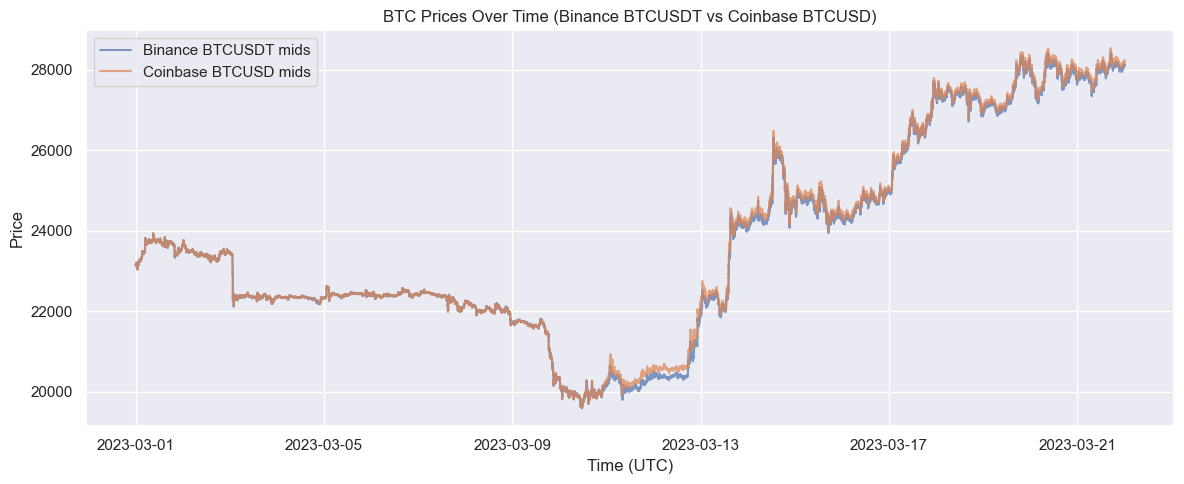

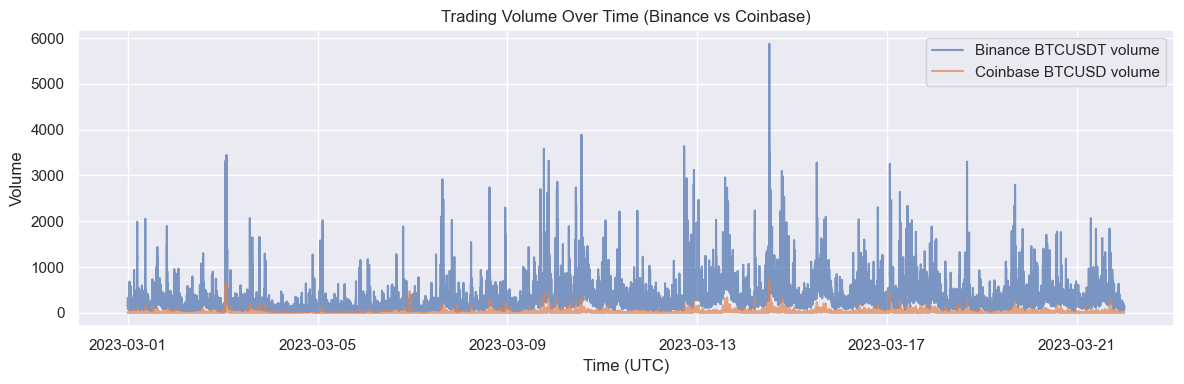

In [216]:
# Seaborn EDA for BTCUSDT and BTCUSD (cleaned, aligned data)

# change "close" to "mids" by calculating the mid price as (high + low) / 2 for a more stable price comparison
df_btcusdt["mids"] = (df_btcusdt["high"] + df_btcusdt["low"]) / 2
df_btcusd["mids"] = (df_btcusd["high"] + df_btcusd["low"]) / 2

# Plot BTCUSDT and BTCUSD mid prices over time

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_btcusdt.index, df_btcusdt["mids"], label="Binance BTCUSDT mids", alpha=0.7)

ax.plot(df_btcusd.index, df_btcusd["mids"], label="Coinbase BTCUSD mids", alpha=0.7)

ax.set_title("BTC Prices Over Time (Binance BTCUSDT vs Coinbase BTCUSD)")

ax.set_xlabel("Time (UTC)")

ax.set_ylabel("Price")

ax.legend()

plt.tight_layout()

plt.show()



# Plot volumes for both venues on the overlapping window

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df_btcusdt.index, df_btcusdt["volume"], label="Binance BTCUSDT volume", alpha=0.7)

ax.plot(df_btcusd.index, df_btcusd["volume"], label="Coinbase BTCUSD volume", alpha=0.7)

ax.set_title("Trading Volume Over Time (Binance vs Coinbase)")

ax.set_xlabel("Time (UTC)")

ax.set_ylabel("Volume")

ax.legend()

plt.tight_layout()

plt.show()


# 10. Add Basic Return Features

Compute simple and log returns, plus rolling volatility from BTCUSDT prices for downstream modelling and basis work.

In [217]:
# Add return and volatility features to the cleaned BTCUSDT DataFrame



# Simple and log returns based on close prices

df_btcusdt["ret_simple"] = df_btcusdt["close"].pct_change()

df_btcusdt["ret_log"] = np.log(df_btcusdt["close"]).diff()



# Rolling 60-minute volatility of log returns

df_btcusdt["vol_60m"] = df_btcusdt["ret_log"].rolling(60).std()



print("BTCUSDT with return/volatility features:")

print(df_btcusdt[["close", "ret_simple", "ret_log", "vol_60m"]].head(10))


BTCUSDT with return/volatility features:
                              close  ret_simple   ret_log  vol_60m
timestamp                                                         
2023-03-01 00:00:00+00:00  23143.73         NaN       NaN      NaN
2023-03-01 00:01:00+00:00  23139.15   -0.000198 -0.000198      NaN
2023-03-01 00:02:00+00:00  23157.00    0.000771  0.000771      NaN
2023-03-01 00:03:00+00:00  23158.53    0.000066  0.000066      NaN
2023-03-01 00:04:00+00:00  23178.71    0.000871  0.000871      NaN
2023-03-01 00:05:00+00:00  23172.93   -0.000249 -0.000249      NaN
2023-03-01 00:06:00+00:00  23152.32   -0.000889 -0.000890      NaN
2023-03-01 00:07:00+00:00  23134.26   -0.000780 -0.000780      NaN
2023-03-01 00:08:00+00:00  23139.31    0.000218  0.000218      NaN
2023-03-01 00:09:00+00:00  23120.06   -0.000832 -0.000832      NaN


# 11. Wire Up Simple Tests for Data Integrity

We can create tests in tests/test_data_integrity.py that check BTCUSDT data properties
(no NaNs, increasing timestamps, valid price relationships). This section shows how to invoke pytest.

In [218]:
# Optional: run pytest from this notebook to execute data integrity tests

# (requires tests to be implemented in tests/test_data_integrity.py)

#

# Uncomment the line below to run tests:

# !pytest -q


# Data Notes: Missing BTCUSD Minutes

From the cleaning/alignment step we observed:

- `BTCUSD missing rows after reindex: 290`

This reflects minutes where Coinbase BTC-USD has **no candle**, which is
consistent with brief daily pauses / gaps (around ~10 minutes per day over
this window). For the Q1 analysis, we should:

- Treat these as genuine "no-trade" intervals rather than errors.
- When constructing the basis, either:
  - Drop minutes where **either** `close_usdt` or `close_usd` is missing; or
  - Forward-fill short gaps in prices if we prefer a fully continuous series.

We will make this handling choice explicit in the Q1 methodology write-up.

In [219]:
# 12. Construct Basis Series (BTC/USDT vs BTC/USD)

# Drop minutes where either close_usdt or close_usd is missing
basis_df = df_prices.dropna(subset=["close_usdt", "close_usd"]).copy()

basis_df["basis"] = np.log(basis_df["close_usdt"]) - np.log(basis_df["close_usd"])

print("Basis DataFrame:", basis_df.shape)
print(basis_df[["close_usdt", "close_usd", "basis"]].head())


Basis DataFrame: (29950, 11)
                           close_usdt  close_usd     basis
2023-03-01 00:00:00+00:00    23143.73   23146.93 -0.000138
2023-03-01 00:01:00+00:00    23139.15   23143.43 -0.000185
2023-03-01 00:02:00+00:00    23157.00   23159.67 -0.000115
2023-03-01 00:03:00+00:00    23158.53   23162.14 -0.000156
2023-03-01 00:04:00+00:00    23178.71   23180.00 -0.000056


In [220]:
# 13. Define Transaction Cost Band (No-Arb Region)

# Taker fees (per trade notional)
fee_binance = 0.001   # 0.1%
fee_coinbase = 0.004  # 0.4%

# Simple symmetric fee band around 0 in log terms.
# We approximate total round-trip cost as the sum of both legs' taker fees.
# For small fees, log(1 + x) ≈ x, so tau ≈ fee_binance + fee_coinbase.

tau_symmetric = fee_binance + fee_coinbase
print("Symmetric fee band tau (approx log no-arb band):", tau_symmetric)

# Direction-specific bands (currently numerically equal, but kept separate so we
# can later allow for asymmetric or time-varying costs by leg).
tau_buy_binance_sell_coinbase = fee_binance + fee_coinbase
tau_buy_coinbase_sell_binance = fee_binance + fee_coinbase

print("tau_buy_binance_sell_coinbase:", tau_buy_binance_sell_coinbase)
print("tau_buy_coinbase_sell_binance:", tau_buy_coinbase_sell_binance)

# Store bands for later persistence and no-arb analysis
basis_df["tau"] = tau_symmetric
basis_df["tau_sym"] = tau_symmetric
basis_df["tau_buy_binance_sell_coinbase"] = tau_buy_binance_sell_coinbase
basis_df["tau_buy_coinbase_sell_binance"] = tau_buy_coinbase_sell_binance


Symmetric fee band tau (approx log no-arb band): 0.005
tau_buy_binance_sell_coinbase: 0.005
tau_buy_coinbase_sell_binance: 0.005


In [221]:
# 14. Quick Descriptive Stats and No-Arb Frequency

# Drop any remaining NaNs in basis just in case
basis_clean = basis_df.dropna(subset=["basis"]).copy()

# Basic summary statistics for the basis
print("Basis summary stats:")
print(basis_clean["basis"].describe())

# How often does the (absolute) basis exceed the symmetric transaction-cost band?
abs_basis = basis_clean["basis"].abs()
exceeds_band_sym = abs_basis > basis_clean["tau"]

share_exceeds_sym = exceeds_band_sym.mean()
print("\nShare of minutes with |basis_t| > tau_sym:", share_exceeds_sym)

# Also report some quantiles of |basis|
print("\nQuantiles of |basis_t|:")
print(abs_basis.quantile([0.5, 0.9, 0.95, 0.99]))

# Direction-specific no-arb conditions (currently same thresholds, but kept separate):
# - Buy on Binance (BTC/USDT), sell on Coinbase (BTC/USD): basis_t > tau_buy_binance_sell_coinbase
# - Buy on Coinbase, sell on Binance:                       basis_t < -tau_buy_coinbase_sell_binance

cond_buy_binance_sell_coinbase = basis_clean["basis"] > basis_clean["tau_buy_binance_sell_coinbase"]
cond_buy_coinbase_sell_binance = basis_clean["basis"] < -basis_clean["tau_buy_coinbase_sell_binance"]

share_buy_binance_sell_coinbase = cond_buy_binance_sell_coinbase.mean()
share_buy_coinbase_sell_binance = cond_buy_coinbase_sell_binance.mean()

print("\nShare of minutes with basis_t > tau_buy_binance_sell_coinbase:", share_buy_binance_sell_coinbase)
print("Share of minutes with basis_t < -tau_buy_coinbase_sell_binance:", share_buy_coinbase_sell_binance)


Basis summary stats:
count    29950.000000
mean        -0.002396
std          0.002932
min         -0.018201
25%         -0.003560
50%         -0.002259
75%         -0.000060
max          0.000985
Name: basis, dtype: float64

Share of minutes with |basis_t| > tau_sym: 0.13308848080133556

Quantiles of |basis_t|:
0.50    0.002259
0.90    0.005842
0.95    0.009007
0.99    0.012147
Name: basis, dtype: float64

Share of minutes with basis_t > tau_buy_binance_sell_coinbase: 0.0
Share of minutes with basis_t < -tau_buy_coinbase_sell_binance: 0.13308848080133556


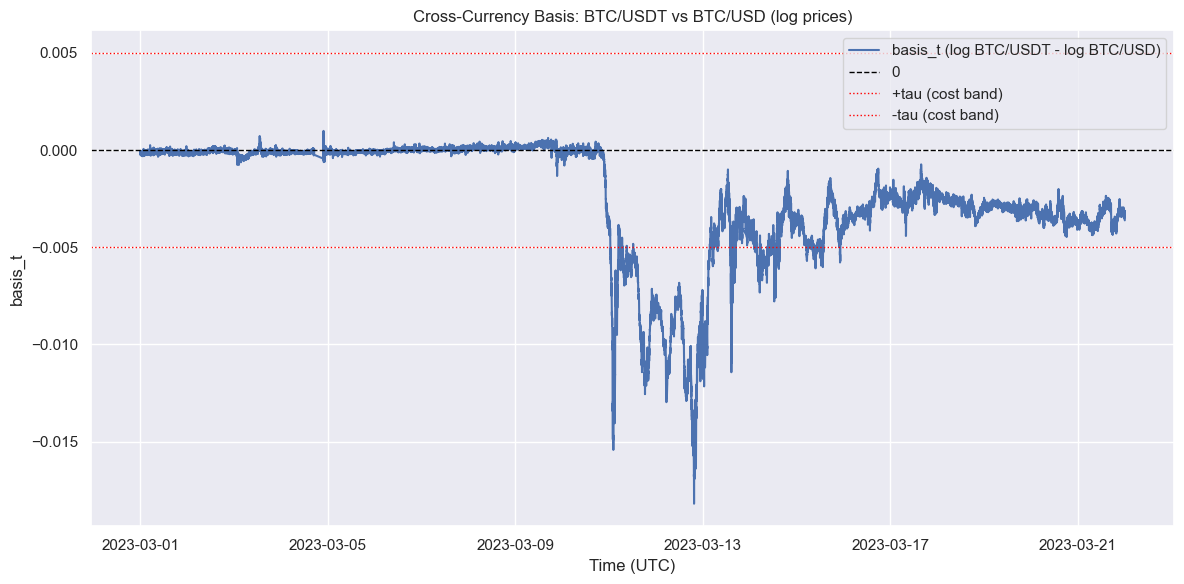

In [222]:
# 15. Plot Basis Over Time with Transaction-Cost Band

# For plotting, it is usually helpful to focus on the main window
# where both legs are present and basis is finite.
plot_df = basis_clean.copy()

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(plot_df.index, plot_df["basis"], label="basis_t (log BTC/USDT - log BTC/USD)", color="C0")
ax.axhline(0.0, color="black", linewidth=1.0, linestyle="--", label="0")
ax.axhline(plot_df["tau"].iloc[0], color="red", linewidth=1.0, linestyle=":", label="+tau (cost band)")
ax.axhline(-plot_df["tau"].iloc[0], color="red", linewidth=1.0, linestyle=":", label="-tau (cost band)")

ax.set_title("Cross-Currency Basis: BTC/USDT vs BTC/USD (log prices)")
ax.set_ylabel("basis_t")
ax.set_xlabel("Time (UTC)")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [223]:
# 16. Persistence Diagnostics: AR(1), ACF, and ADF Test

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller

# Ensure basis_clean has no NaNs in 'basis'
basis_series = basis_clean["basis"].dropna()

# Simple AR(1) via OLS: basis_t = phi * basis_{t-1} + eps_t

# Build lagged DataFrame
ar_df = pd.DataFrame(
    {
        "basis_t": basis_series,
        "basis_lag1": basis_series.shift(1),
    }
).dropna()

X = ar_df[["basis_lag1"]]
X = sm.add_constant(X)
y = ar_df["basis_t"]

ar_model = sm.OLS(y, X).fit()
phi = ar_model.params["basis_lag1"]

print("AR(1) estimate (phi):", phi)

# Half-life of mean reversion (if |phi| < 1)
if abs(phi) < 1:
    half_life = np.log(0.5) / np.log(abs(phi))
    print("Implied half-life (minutes):", half_life)
else:
    print("phi is >= 1 in magnitude; half-life not defined (non-mean-reverting).")

# ACF of basis_t (few lags)
acf_vals = acf(basis_series, nlags=20, fft=True)
print("\nACF (first 5 lags):")
for lag, val in enumerate(acf_vals[:5]):
    print(f"lag {lag}: {val:.4f}")

# Augmented Dickey-Fuller test for stationarity of basis_t
adf_stat, p_value, used_lags, nobs, crit_vals, icbest = adfuller(basis_series.dropna())
print("\nADF test on basis_t:")
print("  test statistic:", adf_stat)
print("  p-value:", p_value)
print("  used lags:", used_lags)
print("  number of observations:", nobs)
print("  critical values:")
for k, v in crit_vals.items():
    print(f"    {k}: {v}")


AR(1) estimate (phi): 0.9984529655335314
Implied half-life (minutes): 447.70229489536814

ACF (first 5 lags):
lag 0: 1.0000
lag 1: 0.9984
lag 2: 0.9977
lag 3: 0.9971
lag 4: 0.9965

ADF test on basis_t:
  test statistic: -2.7679685812277004
  p-value: 0.06299690077470259
  used lags: 49
  number of observations: 29900
  critical values:
    1%: -3.4305687244646665
    5%: -2.8616366702893026
    10%: -2.5668214546470396


# 17. Stress Window and Driver Construction for Q1

We now define a stress period (e.g. March 10–13, 2023, UTC), construct simple liquidity/volatility drivers from the BTC/USD leg, and merge them with the basis series for regression-style analysis. This follows the Q1 plan: explain the basis using stress, volatility, and volume, and allow for persistence via an AR term.

In [224]:
# 18. Build Stress Dummy and Candle-Based Drivers



# We use the aligned BTCUSD leg to construct drivers:

# - ret_usd: 1-minute log returns of BTC/USD

# - rv_usd_60: 60-minute rolling volatility of BTC/USD returns (annualization not needed for Q1)

# - volume_usd: BTC/USD volume (already present in basis_clean from df_prices)

# - stress: dummy for a stress window (here March 10–13, 2023, UTC)



# Start from the full df_prices grid

drivers = df_prices[["close_usd", "volume_usd"]].copy()



# 1-minute log returns of BTC/USD

drivers["ret_usd"] = np.log(drivers["close_usd"]).diff()



# 60-minute rolling volatility of returns

window = 60

drivers["rv_usd_60"] = drivers["ret_usd"].rolling(window).std()



# Stress dummy: March 10–13, 2023 inclusive (UTC)

stress_start = pd.Timestamp("2023-03-10 00:00:00", tz="UTC")

stress_end = pd.Timestamp("2023-03-13 23:59:00", tz="UTC")

drivers["stress"] = ((drivers.index >= stress_start) & (drivers.index <= stress_end)).astype(int)



# Join drivers onto the cleaned basis DataFrame.

# We only join new columns (ret_usd, rv_usd_60, stress) to avoid overlapping volume_usd.

basis_drivers = basis_clean.join(

    drivers[["ret_usd", "rv_usd_60", "stress"]],

    how="left",

)



# Drop rows where we don't have the necessary driver data

basis_drivers = basis_drivers.dropna(subset=["basis", "ret_usd", "rv_usd_60", "volume_usd"])



print("basis_drivers columns:", basis_drivers.columns.tolist())

print("basis_drivers shape:", basis_drivers.shape)


basis_drivers columns: ['open_usdt', 'high_usdt', 'low_usdt', 'close_usdt', 'volume_usdt', 'open_usd', 'high_usd', 'low_usd', 'close_usd', 'volume_usd', 'basis', 'tau', 'tau_sym', 'tau_buy_binance_sell_coinbase', 'tau_buy_coinbase_sell_binance', 'ret_usd', 'rv_usd_60', 'stress']
basis_drivers shape: (29697, 18)


# 19. Basis Histograms (Overall and by Regime)

We now visualize the distribution of the basis, both overall and split into normal vs stress regimes, to see how much it widens during stress episodes.

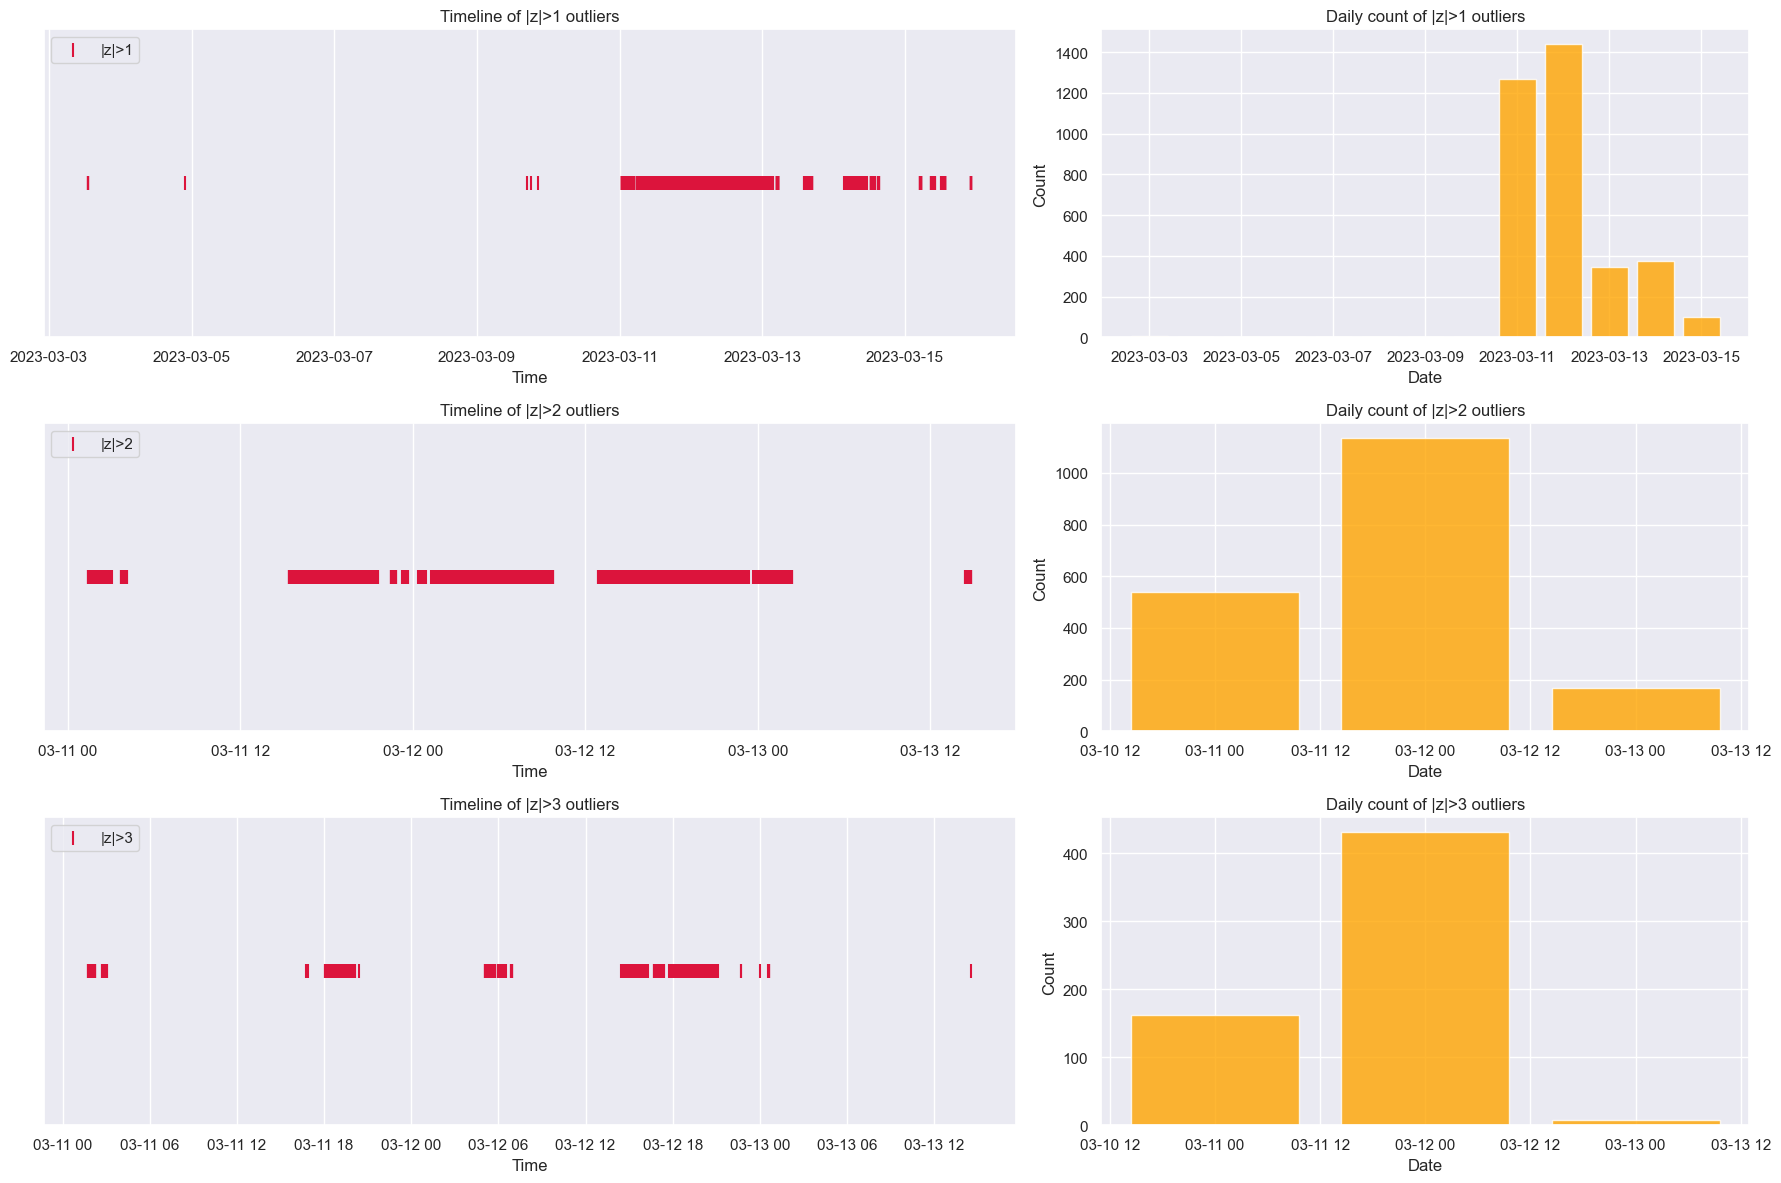

In [225]:
# Outlier timeline and frequency analysis for 1, 2, 3 sigma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

fig_dir = PROJECT_ROOT / "figures"

os.makedirs(fig_dir, exist_ok=True)
basis_z = (basis_df["basis"] - basis_df["basis"].mean()) / basis_df["basis"].std()

fig, axes = plt.subplots(3, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [3, 2]})
sigmas = [1, 2, 3]
for i, sigma in enumerate(sigmas):
    mask = np.abs(basis_z) > sigma
    outlier_times = basis_z.index[mask]
    # Timeline plot (scatter)
    axes[i, 0].scatter(outlier_times, np.ones_like(outlier_times), marker='|', color='crimson', s=100, label=f'|z|>{sigma}')
    axes[i, 0].set_ylim(0.8, 1.2)
    axes[i, 0].set_yticks([])
    axes[i, 0].set_title(f'Timeline of |z|>{sigma} outliers')
    axes[i, 0].set_xlabel('Time')
    axes[i, 0].legend(loc='upper left')
    # Rolling/daily count plot
    outlier_series = pd.Series(1, index=outlier_times)
    daily_counts = outlier_series.resample('D').sum()
    axes[i, 1].bar(daily_counts.index, daily_counts.values, color='orange', alpha=0.8)
    axes[i, 1].set_title(f'Daily count of |z|>{sigma} outliers')
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Count')
plt.tight_layout()
plt.savefig(fig_dir / 'fig_outlier_timeline_multi.png')
plt.show()

In [226]:
# Save key figures as PNG files for the written report

import os

from matplotlib import pyplot as plt



fig_dir = PROJECT_ROOT / "figures"

os.makedirs(fig_dir, exist_ok=True)



# 1) Mid prices over time (using mid prices based on highs/lows)

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_btcusdt.index, df_btcusdt["mids"], label="Binance BTCUSDT mids", alpha=0.8)

ax.plot(df_btcusd.index, df_btcusd["mids"], label="Coinbase BTCUSD mids", alpha=0.8)

ax.set_title("BTCUSDT vs BTCUSD mid prices (1-minute)")

ax.set_ylabel("Price (USD)")

ax.set_xlabel("Time (UTC)")

ax.legend()

fig.tight_layout()

fig.savefig(fig_dir / "fig_mid_prices.png", dpi=200)

plt.close(fig)



# 2) Volumes over time

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_btcusdt.index, df_btcusdt["volume"], label="Binance BTCUSDT volume", alpha=0.8)

ax.plot(df_btcusd.index, df_btcusd["volume"], label="Coinbase BTCUSD volume", alpha=0.8)

ax.set_title("Trading volume by venue (1-minute)")

ax.set_ylabel("Volume (BTC)")

ax.set_xlabel("Time (UTC)")

ax.legend()

fig.tight_layout()

fig.savefig(fig_dir / "fig_volumes.png", dpi=200)

plt.close(fig)



# 3) Basis over time with transaction-cost band

fig, ax = plt.subplots(figsize=(10, 4))

basis_df["basis"].plot(ax=ax, color="tab:blue", linewidth=0.6, label="basis_t")

ax.axhline(0.0, color="black", linewidth=1.0, linestyle="-", label="0")

ax.axhline(tau_symmetric, color="red", linewidth=0.8, linestyle="--", label="± tau (cost band)")

ax.axhline(-tau_symmetric, color="red", linewidth=0.8, linestyle="--")

ax.set_title("BTCUSDT–BTCUSD log basis with 0.5% cost band")

ax.set_ylabel("Log basis")

ax.set_xlabel("Time (UTC)")

ax.legend(loc="upper right")

fig.tight_layout()

fig.savefig(fig_dir / "fig_basis_with_band.png", dpi=200)

plt.close(fig)



# 4) Basis histograms: overall, normal vs stress

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)



# Use basis and stress from the same DataFrame to avoid alignment issues

basis_series = basis_drivers["basis"].dropna()

basis_series.hist(ax=axes[0], bins=50, color="tab:blue")

axes[0].set_title("Basis: full sample")

axes[0].set_xlabel("Log basis")



basis_normal = basis_drivers.loc[basis_drivers["stress"] == 0, "basis"].dropna()

basis_normal.hist(ax=axes[1], bins=40, color="tab:green")

axes[1].set_title("Basis: normal periods")

axes[1].set_xlabel("Log basis")



basis_stress = basis_drivers.loc[basis_drivers["stress"] == 1, "basis"].dropna()

basis_stress.hist(ax=axes[2], bins=40, color="tab:orange")

axes[2].set_title("Basis: stress periods")

axes[2].set_xlabel("Log basis")



fig.tight_layout()

fig.savefig(fig_dir / "fig_basis_histograms.png", dpi=200)

plt.close(fig)



print(f"Saved figures to {fig_dir}")

Saved figures to /Users/tobias/Desktop/PROG/IAQF/figures


# 21. Driver Regression: What Explains the Basis?

We now run a simple regression of the basis on:

- Stress dummy (March 10–13),

- Realized volatility proxy from BTC/USD candles (rv_usd_60),

- BTC/USD volume,

and include an AR(1) term in the basis to capture persistence. This directly addresses the Q1 question: what drives the cross-currency basis, controlling for persistence.

In [227]:
# 22. Run Driver Regression with AR(1) Term



# Prepare regression DataFrame

reg_df = basis_drivers.copy()



# Add AR(1) term in basis

reg_df["basis_lag1"] = reg_df["basis"].shift(1)



# Drop rows with missing values in regressors or dependent variable

reg_df = reg_df.dropna(subset=["basis", "basis_lag1", "stress", "rv_usd_60", "volume_usd"])



# Optional: scale volume to avoid very large numbers (e.g., divide by median)

volume_scale = reg_df["volume_usd"].median()

if volume_scale > 0:

    reg_df["volume_usd_scaled"] = reg_df["volume_usd"] / volume_scale

else:

    reg_df["volume_usd_scaled"] = reg_df["volume_usd"]



X = reg_df[["stress", "rv_usd_60", "volume_usd_scaled", "basis_lag1"]]

X = sm.add_constant(X)

y = reg_df["basis"]



driver_model = sm.OLS(y, X).fit()

print(driver_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  basis   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.420e+06
Date:                Thu, 12 Feb 2026   Prob (F-statistic):               0.00
Time:                        12:47:06   Log-Likelihood:             2.1698e+05
No. Observations:               29696   AIC:                        -4.339e+05
Df Residuals:                   29691   BIC:                        -4.339e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.837e-06   1.71e-0

# 23. AR(1) Comparison: Normal vs Stress Regimes

As a final persistence check, we estimate separate AR(1) coefficients for normal vs stress periods to see whether the basis is more persistent during stress.

In [228]:
# 24. Estimate AR(1) Separately for Normal vs Stress



def estimate_ar1_phi(series: pd.Series) -> float:

    """Estimate AR(1) coefficient phi for a given series via OLS."""

    s = series.dropna()

    ar_df = pd.DataFrame({

        "y": s,

        "y_lag1": s.shift(1),

    }).dropna()

    if len(ar_df) < 50:

        return np.nan

    X_local = sm.add_constant(ar_df["y_lag1"])

    y_local = ar_df["y"]

    res = sm.OLS(y_local, X_local).fit()

    return res.params.get("y_lag1", np.nan)



# Split basis by regime using basis_drivers['stress']

basis_normal = basis_drivers.loc[basis_drivers["stress"] == 0, "basis"]

basis_stress = basis_drivers.loc[basis_drivers["stress"] == 1, "basis"]



phi_normal = estimate_ar1_phi(basis_normal)

phi_stress = estimate_ar1_phi(basis_stress)



print("AR(1) phi in normal periods:", phi_normal)

if not np.isnan(phi_normal) and abs(phi_normal) < 1:

    hl_normal = np.log(0.5) / np.log(abs(phi_normal))

    print("  Half-life (minutes), normal:", hl_normal)



print("\nAR(1) phi in stress periods:", phi_stress)

if not np.isnan(phi_stress) and abs(phi_stress) < 1:

    hl_stress = np.log(0.5) / np.log(abs(phi_stress))

    print("  Half-life (minutes), stress:", hl_stress)


AR(1) phi in normal periods: 0.9972042073703972
  Half-life (minutes), normal: 247.57836944454024

AR(1) phi in stress periods: 0.9979693216468661
  Half-life (minutes), stress: 340.9910592536682


In [229]:
# Helper summary cell for Q1 interpretation (can be deleted later)
import numpy as np

print("=== Basis level stats ===")
print("mean(basis):", float(basis_series.mean()))
print("std(basis):", float(basis_series.std()))
print("quantiles (0.01, 0.05, 0.5, 0.95, 0.99):",
      tuple(np.round(basis_series.quantile([0.01, 0.05, 0.5, 0.95, 0.99]), 6)))

print("\n=== Cost-band exceedance ===")
print("share |basis| > tau_sym:", float(share_exceeds_sym))
print("share basis > tau_buy_binance_sell_coinbase:", float(share_buy_binance_sell_coinbase))
print("share basis < -tau_buy_coinbase_sell_binance:", float(share_buy_coinbase_sell_binance))

# Also report counts of cost-band exceedances
n_total = int(len(basis_clean))
n_exceeds = int(exceeds_band_sym.sum())
print("N (basis_clean):", n_total)
print("N with |basis_t| > tau_sym:", n_exceeds)

print("\n=== AR(1) overall ===")
print("phi (overall):", float(phi))
print("half-life (min, overall):", float(half_life))

print("\n=== Stationarity (ADF) ===")
print("ADF stat:", float(adf_stat))
print("ADF p-value:", float(p_value))

print("\n=== Driver regression (selected coefs) ===")
for name, val in driver_model.params.items():
    if name in ["const", "stress", "rv_usd_60", "volume_usd_scaled", "basis_lag1"]:
        print(f"{name}: {val}")

print("\n=== Z-score extremes ===")
z = (basis_series - basis_series.mean()) / basis_series.std()
share_2sigma = (z.abs() > 2).mean()
share_3sigma = (z.abs() > 3).mean()
print("share |basis - mean| > 2σ:", float(share_2sigma))
print("share |basis - mean| > 3σ:", float(share_3sigma))

=== Basis level stats ===
mean(basis): -0.002415359155708332
std(basis): 0.0029367658097565223
quantiles (0.01, 0.05, 0.5, 0.95, 0.99): (-0.012167, -0.009023, -0.002309, 0.000152, 0.000322)

=== Cost-band exceedance ===
share |basis| > tau_sym: 0.13308848080133556
share basis > tau_buy_binance_sell_coinbase: 0.0
share basis < -tau_buy_coinbase_sell_binance: 0.13308848080133556
N (basis_clean): 29950
N with |basis_t| > tau_sym: 3986

=== AR(1) overall ===
phi (overall): 0.9984529655335314
half-life (min, overall): 447.70229489536814

=== Stationarity (ADF) ===
ADF stat: -2.7679685812277004
ADF p-value: 0.06299690077470259

=== Driver regression (selected coefs) ===
const: -1.8374742212344004e-06
stress: -1.0862323101907932e-05
rv_usd_60: -0.004441277881361436
volume_usd_scaled: 5.21997766273797e-07
basis_lag1: 0.9974419136364806

=== Z-score extremes ===
share |basis - mean| > 2σ: 0.061487692359497595
share |basis - mean| > 3σ: 0.019732632925884768


# Advanced Statistical and Economic Analyses

This section extends the core basis analysis with advanced econometric, trading, and robustness checks as requested.

## 1. Co-integration and Granger Causality

We test for co-integration and Granger causality between BTCUSDT and BTCUSD log prices. This helps determine if the two series are linked by a long-run equilibrium and if one can help forecast the other.

In [230]:
# Co-integration and Granger causality tests
from statsmodels.tsa.stattools import coint, grangercausalitytests

# Prepare aligned log price series
df_coint = basis_df.dropna(subset=["close_usdt", "close_usd"]).copy()
log_usdt = np.log(df_coint["close_usdt"])
log_usd = np.log(df_coint["close_usd"])

# Johansen test (if available)
try:
    from statsmodels.tsa.vector_ar.vecm import coint_johansen
    johansen_result = coint_johansen(df_coint[["close_usdt", "close_usd"]].apply(np.log), det_order=0, k_ar_diff=1)
    print("Johansen test eigenvalues:", johansen_result.lr1)
    print("Johansen test critical values:", johansen_result.cvt)
except ImportError:
    print("statsmodels >=0.10 required for Johansen test. Skipping.")

# Engle-Granger two-step test
coint_result = coint(log_usdt, log_usd)
coint_stat = coint_result[0]
coint_p = coint_result[1]
print(f"Engle-Granger coint p-value: {coint_p:.4g}")

# Granger causality (does one help forecast the other?)
maxlag = 5
gc_usdt_to_usd = grangercausalitytests(df_coint[["close_usd", "close_usdt"]], maxlag=maxlag, verbose=False)
gc_usd_to_usdt = grangercausalitytests(df_coint[["close_usdt", "close_usd"]], maxlag=maxlag, verbose=False)
print("Granger causality p-values (USDT->USD):", [gc_usdt_to_usd[l][0]['ssr_ftest'][1] for l in range(1, maxlag+1)])
print("Granger causality p-values (USD->USDT):", [gc_usd_to_usdt[l][0]['ssr_ftest'][1] for l in range(1, maxlag+1)])

Johansen test eigenvalues: [26.75153651  0.13811936]
Johansen test critical values: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Engle-Granger coint p-value: 0.1774
Granger causality p-values (USDT->USD): [np.float64(0.016876354089696677), np.float64(6.061528995843204e-15), np.float64(1.8698015842860025e-16), np.float64(1.3894487901800866e-15), np.float64(3.2614336183844152e-15)]
Granger causality p-values (USD->USDT): [np.float64(0.0008212862472057495), np.float64(0.0010127123637760146), np.float64(0.00206104065637407), np.float64(0.00167132620708207), np.float64(0.0019528008861975277)]


/Users/tobias/Desktop/PROG/IAQF/.venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/tobias/Desktop/PROG/IAQF/.venv/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## 2. Rolling Volatility and Return Correlation

We compute rolling 60-minute volatility for both BTCUSDT and BTCUSD, and the rolling correlation of their 1-minute log returns. This helps assess how tightly the two markets move together and whether volatility regimes differ.

In [231]:
# Rolling volatility and return correlation
window = 60  # 60-minute window

df_roll = basis_df.dropna(subset=["close_usdt", "close_usd"]).copy()
df_roll["logret_usdt"] = np.log(df_roll["close_usdt"]).diff()
df_roll["logret_usd"] = np.log(df_roll["close_usd"]).diff()

# Rolling volatilities
vol_usdt = df_roll["logret_usdt"].rolling(window).std()
vol_usd = df_roll["logret_usd"].rolling(window).std()

# Rolling correlation
roll_corr = df_roll["logret_usdt"].rolling(window).corr(df_roll["logret_usd"])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(vol_usdt, label="BTCUSDT vol", color="tab:blue")
ax[0].plot(vol_usd, label="BTCUSD vol", color="tab:orange")
ax[0].set_ylabel("60-min Volatility")
ax[0].legend()
ax[0].set_title("Rolling 60-min Volatility")

ax[1].plot(roll_corr, label="Rolling corr", color="tab:green")
ax[1].set_ylabel("Corr(USDT, USD)")
ax[1].set_xlabel("Time")
ax[1].set_title("Rolling 60-min Return Correlation")
fig.tight_layout()
fig.savefig(PROJECT_ROOT / "figures" / "fig_rolling_vol_corr.png", dpi=200)
plt.close(fig)
print("Saved rolling volatility and correlation figure.")

Saved rolling volatility and correlation figure.


## 3. Outlier Clustering and Intraday/Seasonality Analysis

We analyze the clustering of large basis outliers and examine whether dislocations are more likely at certain hours of the day (Asia, Europe, US sessions).

In [232]:
# Outlier clustering and intraday/seasonality
basis_z = (basis_df["basis"] - basis_df["basis"].mean()) / basis_df["basis"].std()
outlier_mask = basis_z.abs() > 2
outlier_times = basis_df.index[outlier_mask]

# Inter-event times (in minutes)
inter_event = (outlier_times[1:] - outlier_times[:-1]).total_seconds() / 60

# Hour-of-day analysis
basis_df["hour"] = basis_df.index.hour
hourly_outlier_counts = outlier_mask.groupby(basis_df["hour"]).sum()
hourly_total_counts = basis_df["hour"].value_counts().sort_index()
hourly_outlier_rate = hourly_outlier_counts / hourly_total_counts

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].hist(inter_event, bins=50, color="tab:purple", alpha=0.7)
ax[0].set_title("Inter-event times between 2σ outliers (minutes)")
ax[0].set_xlabel("Minutes between outliers")
ax[0].set_ylabel("Count")

ax[1].bar(hourly_outlier_rate.index, hourly_outlier_rate.values, color="tab:orange", alpha=0.8)
ax[1].set_title("Hourly outlier rate (|z|>2)")
ax[1].set_xlabel("Hour of day (UTC)")
ax[1].set_ylabel("Outlier frequency")
fig.tight_layout()
fig.savefig(PROJECT_ROOT / "figures" / "fig_outlier_intraday.png", dpi=200)
plt.close(fig)
print("Saved outlier clustering and intraday figure.")

Saved outlier clustering and intraday figure.


## 4. Trade Simulation: Mean-Reversion/Threshold Strategy

We simulate a simple mean-reversion strategy: enter when the basis is below a negative threshold, exit when it reverts or after a holding period. We compute P&L, hit rate, and annualized return.

In [233]:
# Simple mean-reversion trade simulation
# Enter when basis < threshold, exit when basis > exit_threshold or after max_hold minutes
threshold = -0.005  # -0.5%
exit_threshold = -0.001  # -0.1%
max_hold = 360  # 6 hours

trades = []
open_trade = None
for i, (t, row) in enumerate(basis_df.iterrows()):
    if open_trade is None:
        if row["basis"] < threshold:
            open_trade = {"entry_time": t, "entry_basis": row["basis"], "entry_idx": i}
    else:
        # Check exit conditions
        if (row["basis"] > exit_threshold) or (i - open_trade["entry_idx"] >= max_hold):
            open_trade["exit_time"] = t
            open_trade["exit_basis"] = row["basis"]
            open_trade["exit_idx"] = i
            open_trade["pnl"] = open_trade["exit_basis"] - open_trade["entry_basis"]
            open_trade["duration"] = i - open_trade["entry_idx"]
            trades.append(open_trade)
            open_trade = None

import pandas as pd
trades_df = pd.DataFrame(trades)

# Compute stats
n_trades = len(trades_df)
hit_rate = (trades_df["pnl"] > 0).mean() if n_trades > 0 else float('nan')
mean_pnl = trades_df["pnl"].mean() if n_trades > 0 else float('nan')
ann_return = (mean_pnl * 525600 / trades_df["duration"].mean()) if n_trades > 0 else float('nan')  # 525600 min/year
print(f"Trades: {n_trades}, Hit rate: {hit_rate:.2%}, Mean P&L: {mean_pnl:.5f}, Annualized return: {ann_return:.2%}")

# Plot P&L over time
if n_trades > 0:
    trades_df["cum_pnl"] = trades_df["pnl"].cumsum()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(trades_df["exit_time"], trades_df["cum_pnl"], label="Cumulative P&L")
    ax.set_title("Cumulative P&L of Mean-Reversion Strategy")
    ax.set_ylabel("Cumulative P&L (log basis units)")
    ax.set_xlabel("Time")
    ax.legend()
    fig.tight_layout()
    fig.savefig(PROJECT_ROOT / "figures" / "fig_trade_simulation.png", dpi=200)
    plt.close(fig)
    print("Saved trade simulation figure.")

Trades: 17, Hit rate: 70.59%, Mean P&L: 0.00070, Annualized return: 102.36%
Saved trade simulation figure.


## 5. Risk Metrics: VaR, Max Drawdown, Position Sizing

We compute Value-at-Risk (VaR), maximum drawdown, and illustrate the effect of leverage/position sizing on strategy risk and return.

In [234]:
# Risk metrics for the trade simulation
if len(trades_df) > 0:
    # VaR at 95%
    var_95 = trades_df["pnl"].quantile(0.05)
    # Max drawdown
    cum_pnl = trades_df["pnl"].cumsum()
    roll_max = cum_pnl.cummax()
    drawdown = cum_pnl - roll_max
    max_dd = drawdown.min()
    # Leverage scenarios
    leverages = [1, 5, 10]
    fig, ax = plt.subplots(figsize=(10, 4))
    for lev in leverages:
        ax.plot(trades_df["exit_time"], lev * cum_pnl, label=f"{lev}x leverage")
    ax.set_title("Cumulative P&L under Leverage Scenarios")
    ax.set_ylabel("Cumulative P&L (log basis units)")
    ax.set_xlabel("Time")
    ax.legend()
    fig.tight_layout()
    fig.savefig(PROJECT_ROOT / "figures" / "fig_risk_leverage.png", dpi=200)
    plt.close(fig)
    print(f"VaR_95: {var_95:.5f}, Max drawdown: {max_dd:.5f}")
    print("Saved risk/leverage figure.")

VaR_95: -0.00639, Max drawdown: -0.00934
Saved risk/leverage figure.


## 6. Economic Decomposition: USDT Credit Risk vs Exchange Effects (Scaffold)

To decompose the basis into USDT credit risk and exchange-specific effects, add a third USD venue (e.g., Kraken BTC/USD) or a USDT/USD proxy (e.g., USDT/USD spot or index). Once available, repeat the basis and cost-band analysis for all pairs and compare.

In [235]:
# Placeholder for economic decomposition
# Example: If you have Kraken BTC/USD or USDT/USD spot, load and align as with other venues
# Then compute basis_kraken = log(BTCUSDT_Binance) - log(BTCUSD_Kraken)
# and basis_usdtusd = log(BTCUSDT_Binance) - log(BTCUSD_Coinbase) - log(USDT/USD)
# Repeat cost-band and regime analysis for each pair
print("Add third USD venue or USDT/USD proxy data here for decomposition analysis.")

Add third USD venue or USDT/USD proxy data here for decomposition analysis.


## 7. Intraday Pattern: Hour/Session Effects

We analyze whether basis dislocations and cost-band exceedances are more likely during certain hours or market sessions (Asia, Europe, US).

In [236]:
# Intraday/session pattern for cost-band exceedance
basis_df["session"] = pd.cut(basis_df.index.hour,
    bins=[0, 7, 15, 24],
    labels=["Asia", "Europe", "US"],
    right=False, include_lowest=True)
session_exceed = exceeds_band_sym.groupby(basis_df["session"]).mean()
hourly_exceed = exceeds_band_sym.groupby(basis_df.index.hour).mean()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(hourly_exceed.index, hourly_exceed.values, color="tab:blue")
ax[0].set_title("Cost-band exceedance by hour")
ax[0].set_xlabel("Hour (UTC)")
ax[0].set_ylabel("Share |basis| > τ")
ax[1].bar(session_exceed.index.astype(str), session_exceed.values, color="tab:green")
ax[1].set_title("Cost-band exceedance by session")
ax[1].set_xlabel("Session")
ax[1].set_ylabel("Share |basis| > τ")
fig.tight_layout()
fig.savefig(PROJECT_ROOT / "figures" / "fig_intraday_session.png", dpi=200)
plt.close(fig)
print("Saved intraday/session pattern figure.")

Saved intraday/session pattern figure.


## 8. Robustness: Fee Assumptions and Mids vs Closes

We repeat the cost-band exceedance and key stats using alternative fee assumptions and using mid prices instead of closes.

In [237]:
# Robustness: try lower and higher fee bands, and use mids
fee_bands = [0.003, 0.005, 0.007]  # 0.3%, 0.5%, 0.7%
for tau_test in fee_bands:
    exceeds = basis_df["basis"].abs() > tau_test
    share = exceeds.mean()
    print(f"Fee band {tau_test:.3%}: share |basis| > τ = {share:.2%}")

# Using mid prices instead of closes
if "mid_usdt" in basis_df.columns and "mid_usd" in basis_df.columns:
    basis_mid = np.log(basis_df["mid_usdt"]) - np.log(basis_df["mid_usd"])
    exceeds_mid = basis_mid.abs() > tau_symmetric
    share_mid = exceeds_mid.mean()
    print(f"Using mids: share |basis| > τ = {share_mid:.2%}")
else:
    print("Mid prices not available in basis_df. Skipping mids robustness.")

Fee band 0.300%: share |basis| > τ = 36.42%
Fee band 0.500%: share |basis| > τ = 13.31%
Fee band 0.700%: share |basis| > τ = 7.92%
Mid prices not available in basis_df. Skipping mids robustness.
